# Getting Started with FlyGym

In this example, we will demonstrate how to control a fly in a physics-based simulation. As a basic example, we will actuate all leg degrees of freedom (DoF) using sine waves. That is, each DoF will oscillate in a sinusoidal pattern.

If you're using Google Colab, begin by running the cell below. It will perform the necessary configuration. If you're not using Colab, you can still run it, but it won’t affect your local environment.


In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import flygym
    FLYGYM_INSTALLED = True
except ImportError:
    FLYGYM_INSTALLED = False

if not FLYGYM_INSTALLED:
    if IN_COLAB:
        print(
            "I'm on Colab and FlyGym is not installed. I will try to install it now. "
            "This will take a minute."
        )
        import subprocess
        subprocess.run(
            'pip install "flygym[examples]" "mujoco==3.2.2" "dm_control==1.0.22"',
            shell=True
        )
    else:
        print(
            "FlyGym is not installed, and I'm on your own computer. I can try to "
            "install it here, but I don't want to modify your Python environment "
            "unintentionally. Please install FlyGym yourself following instructions "
            "from https://neuromechfly.org/installation.html"
        )

if IN_COLAB:
    print("In Google Colab. I will now perform some Colab-specific setups.")
    # Set up GPU a few more and rendering parameters. This should take ~1 second.
    from google.colab import files
    import distutils.util
    import os
    import subprocess

    if subprocess.run("nvidia-smi").returncode:
        raise RuntimeError(
            "Cannot communicate with GPU. "
            "Make sure you are using a GPU Colab runtime. "
            "Go to the Runtime menu and select Choose runtime type."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
            f.write(
"""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
            )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print("Setting environment variable to use GPU rendering:")
    %env MUJOCO_GL=egl

    try:
        print("Checking that the installation succeeded:")
        import mujoco

        mujoco.MjModel.from_xml_string("<mujoco/>")
    except Exception as e:
        raise e from RuntimeError(
            "Something went wrong during installation. Check the shell output above "
            "for more information.\n"
            "If using a hosted Colab runtime, make sure you enable GPU acceleration "
            'by going to the Runtime menu and selecting "Choose runtime type".'
        )

    print("Installation successful.")

We are now ready to start programming with FlyGym, the Python library that implements NeuroMechFly.

The fruit fly has numerous DoFs, but we will focus on the actively controlled leg DoFs. Each leg has seven:
- Thorax-coxa pitch
- Thorax-coxa roll
- Thorax-coxa yaw
- Coxa-femur pitch
- Coxa-femur roll
- Femur-tibia pitch
- Tibia-tarsus pitch

For convenience, we have predefined these DoFs in a hard-coded list that you can simply import:

In [2]:
from flygym.preprogrammed import all_leg_dofs

print(all_leg_dofs)

['joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1']


Next, we will generate the sine wave representing the deviation of DoF angles from the initial position. We can use NumPy to generate these signals:


In [3]:
import numpy as np

# Some parameters for the simulation
simulated_time = 0.5  # we will simulate 1 second of behavior
freq = 5  # let the DoFs oscillate at 5 Hz
amp = np.deg2rad(30)  # let the amplitude of the oscillation be 30 deg
physics_dt = 1e-4  # we will simulate the physics at a time step of 0.0001s
num_steps = int(simulated_time / physics_dt)
num_dofs = 6 * 7  # 6 legs, 7 DoFs per leg

# Let's generate a time grid from 0s to 1s, with a spacing of 0.0001s
times = np.arange(num_steps) * physics_dt

# Now, we can generate the sine wave. This will be the deviation of DoF
# angles from the initial positions.
delta_dof_angles = amp * np.sin(2 * np.pi * freq * times)

print("Time grid:", times)
print("Delta DoF angles:", delta_dof_angles)

Time grid: [0.000e+00 1.000e-04 2.000e-04 ... 4.997e-01 4.998e-01 4.999e-01]
Delta DoF angles: [0.         0.00164493 0.00328985 ... 0.00493473 0.00328985 0.00164493]


Let's take a look at the control signals visually:

Text(0.5, 1.0, 'Offset of DoF angles from initial positions')

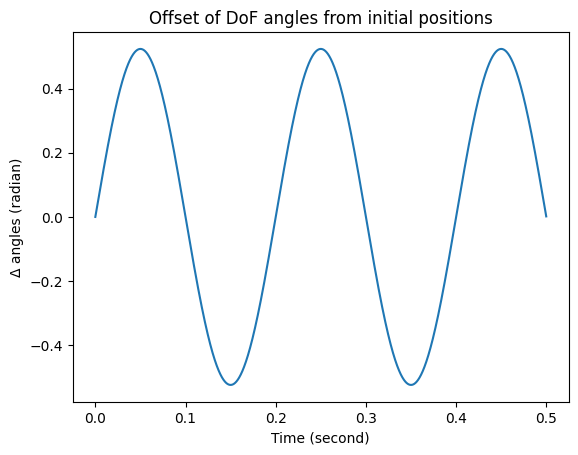

In [4]:
import matplotlib.pyplot as plt

plt.plot(times, delta_dof_angles)
plt.xlabel("Time (second)")
plt.ylabel("Δ angles (radian)")
plt.title("Offset of DoF angles from initial positions")

Now, we can set up the FlyGym simulation. We start by creating a `Fly` object:

In [5]:
from flygym import Fly

fly = Fly(
    name="Nuro",  # identifier for the fly
    spawn_pos=(0, 0, 5),  # we will drop the fly from a height of 5mm
    actuated_joints=all_leg_dofs,  # we will actuate all active leg DoFs
)

Then, we can create a `Camera` object to record the fly:

In [6]:
from flygym import Camera

camera = Camera(
    fly=fly,  # attach the camera to the fly above
    camera_id="Animat/camera_left",  # use the left side view camera
    play_speed=0.1,  # replay the recording at 0.1x speed
    fps=30,  # the replay will be rendered at 30 FPS
             # (considering the 0.1x speed, we actually record at 300Hz)
    timestamp_text=True,  # add time stamp to the rendered images
    play_speed_text=True,  # also stamp the play speed on the images
)

With these, we can create the `Simulation` object itself:

In [7]:
from flygym import Simulation

sim = Simulation(
    flies=[fly],  # we can simulate multiple flies, but we only have one
    cameras=[camera],  # we can have multiple cameras, but we only have one
    timestep=physics_dt,  # set the dt of the physics simulation
)

NeuroMechFly control operates as a Partially Observable Markov Decision Process (POMDP). In a POMDP, the following happens at each time step:
- The **controller** (i.e., nervous system) receives an **observation** from the **task** (i.e., the physics simulation). This observation can include proprioceptive signals, visual inputs, and other sensory information depending on the modeller's choice. Optionally, the controller also receives a **reward**.
- Based on the observation, the controller decides on the next **action**. Depending on the level of abstraction that the modeller desires, the action can be the motor neuron drive, target joint position, etc.
- The **task** (i.e., the physics simulation) executes the action and returns the updated physics state as the next observation.


This process repeats in closed-loop, as demonstrated in the figure below.

![NeuroMechFly control as a POMDP](https://github.com/NeLy-EPFL/_media/blob/main/flygym/nmf_schema_new.png?raw=true)

In our simulation, the task will return three additional pieces of information for the modeller's convenience:
- An arbitrary set of additional *information*, configurable by the modeller. This might include variables the fly itself can't directly perceive but are useful for the modeller, such as the fly's absolute global position or total walking distance.
- Whether or not the task has been *terminated* because a goal has been accomplished. This is particularly useful in reinforcement learning. If it is not applicable, one can make it always return False.
- A true-or-false variable indicating whether the task has been *terminated* — i.e., whether the task has been completed. This is particularly useful in reinforcement learning. If irrelevant, this flag can always return `False`.
- A true-or-false variable indicating whether the task has been *truncated*. Unlike termination, truncation occurs when the simulation ends for reasons outside of the task, such as exceeding a time limit set by the modeller.

Let's reset the simulation to obtain the initial observation (`obs`) and additional information (`info`):

In [8]:
obs, info = sim.reset()

You can access the fly's observation through `obs["Nuro"]`. This is a dictionary containing multiple key-value pairs:

In [9]:
print(obs["Nuro"].keys())

dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'cardinal_vectors'])


For instance, we can retrieve the current joint angles as follows:

In [10]:
initial_dof_angles = obs["Nuro"]["joints"][0, :]
initial_dof_angles

array([ 0.33161256,  0.        ,  0.        , -2.268928  ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.5707964 ,  0.        ,
       -1.7453293 ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.6179938 ,  0.        , -1.7453293 ,  0.        ,  0.        ,
        0.        ,  0.33161256,  0.        ,  0.        , -2.268928  ,
        0.        ,  0.        ,  0.        ,  0.        , -1.5707964 ,
        0.        , -1.7453293 ,  0.        ,  0.        ,  0.        ,
        0.        , -2.6179938 ,  0.        , -1.7453293 ,  0.        ,
        0.        ,  0.        ], dtype=float32)

Why does `obs["Nuro"]["joints"][0, :]` return the current DoF angles? `obs["Nuro"]["joints"]` is a 3×N matrix, where N is the number of actuated DoFs. The three rows of the matrix are the angles, angular velocities, and torques experienced at each DoF respectively. The user is not expected to know this by heart; the full definition of the action and observation spaces can be found in [FlyGym's documentation](https://neuromechfly.org/api_ref/mdp_specs.html).

Next, we add these initial angles to the delta angles time series to get the target angle for each DoF at every time step:

In [11]:
target_dof_angles = np.zeros(shape=(num_dofs, num_steps))
for i in range(num_dofs):
    target_dof_angles[i, :] = initial_dof_angles[i] + delta_dof_angles

Now, let’s run the main simulation loop using the target joint angles obtained above. While the simulation runs, we will record the observation history. Instead of the standard `range` function, we will use `tqdm.trange` to display a progress bar:

In [12]:
from tqdm import trange

obs_hist = []  # Make an empty list to record observations

for i in trange(num_steps):
    # The action is nested dictionary. On the first layer, we specify the
    # action performed by each of the simulated flies (in this case, just
    # Nuro). On the second layer, we specify different types of actions (in
    # this case, we only have joint actions, but in general there can also
    # be things like leg adhesion on/off).
    action = {"Nuro": {"joints": target_dof_angles[:, i]}}

    # Apply the action and get the new observation, etc.
    obs, reward, terminated, truncated, info = sim.step(action)

    # Don't forget to apply `sim.render()` to record the scene using the
    # camera(s) specified in the beginning.
    sim.render()

    obs_hist.append(obs)  # record observation

100%|██████████| 5000/5000 [00:16<00:00, 310.32it/s]


Let’s plot the actual joint angles observed during the simulation, overlaid with the target angles:

Text(0.5, 1.0, 'Target and actual DoF angles, one leg only')

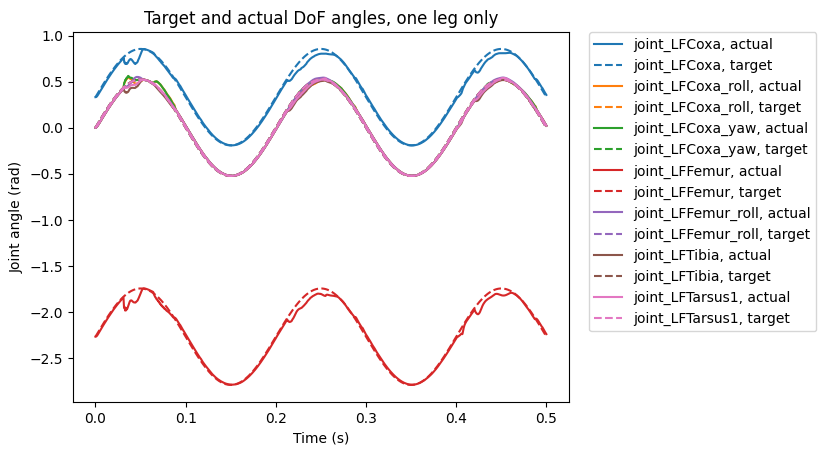

In [13]:
steps_simulated = len(obs_hist)
real_dof_angles = np.array([obs["Nuro"]["joints"][0, :7] for obs in obs_hist]).T
for i, dof in enumerate(all_leg_dofs[:7]):
    color = f"C{i}"
    plt.plot(
        times[:steps_simulated],
        real_dof_angles[i, :],
        color=color,
        linestyle="-",
        label=f"{dof}, actual",
    )
    plt.plot(
        times[:steps_simulated],
        target_dof_angles[i, :steps_simulated],
        color=color,
        linestyle="--",
        label=f"{dof}, target",
    )
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("Time (s)")
plt.ylabel("Joint angle (rad)")
plt.title("Target and actual DoF angles, one leg only")

You may notice that the actual angles do not exactly match the target angles. This discrepancy arises because the joints and actuators have finite stiffness and gain, and they are influenced by passive forces, such as collisions.


Finally, we can save the frames captured by the camera as a video:

In [14]:
camera.save_video("video.mp4")

NeuroMechFly is more than just a tool for graphics rendering; it’s a full-fledged physics-based simulation of a fruit fly’s biomechanics. This means that not all movements specified by the user-defined controller are physically feasible. Some may generate excessive forces, leading to a failure in the simulation’s stability, potentially causing a crash. For example, as an exercise, try increasing the amplitude of the sine wave to 90 degrees, and rerun the simulation. What do you observe?

This simple example is, of course, unrealistic in many ways. However, we hope it demonstrates the basic principles of controlling NeuroMechFly. In the next tutorial, we will explore how to simulate more realistic behaviors with NeuroMechFly.